In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'numbers_gen_10_attention'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
sample_data = all_data.copy()
#sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
#sample_data = sample_data[sample_data['class'] != 'MANUAL']

sample_data =  sample_data[sample_data['class'] == 'NUMBERS']

print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 448170,  (dropped rows: 9470022)


In [7]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['NUMBERS']
1


### Utils stuff

In [8]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [9]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [10]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [11]:
#onehot_sos = torch.zeros(1, 1, len(words_after_index))
#onehot_sos[0, 0, words_after_index[SOS_TOKEN]] = 1
#onehot_sos.size()
#del(onehot_sos)

sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

### More balanced sample

In [12]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_length = 0
def balanced_data_randomize(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_accessed_counter = 0

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_accessed_counter/balanced_data_length > 0.2:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [13]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
NUMBERS    20000
Name: class, dtype: int64

In [14]:
 balanced_data_sample_row()

sentence_id                                               688488
token_id                                                       2
class                                                    NUMBERS
before                                                     1950s
after                                           nineteen fifties
class_org                                                   DATE
a_word_ind                                           [7, 136, 0]
sentence       since the <SAMPLE> , scientists have built sel...
Name: 412676, dtype: object

### Samples

In [15]:
def get_random_sample():
    sample_row = balanced_data_sample_row()
    sentence_id = sample_row['class']
    
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

NUMBERS : 1978 -> nineteen seventy eight <EOS> [7, 33, 16, 0]
" iv copa brasil - <SAMPLE> " .
torch.Size([1, 5, 104])


In [16]:
%%timeit
get_random_sample()

158 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [17]:
use_cuda = True

In [18]:
MAX_ATTENTION_LENGTH = 20

### Encoder

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)
                
        output = torch.cat((output_words[0], output_chars[0]), 0)
        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, hidden_states_cat

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): LSTM(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(104, 128, batch_first=True, bidirectional=True)
)

In [20]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(encoder_output, encoder_outputs), tmp = test_encoder_single_sample()
tmp
encoder_output.size()
encoder_outputs.size()
list(encoder_output.data.cpu().numpy()) == list(encoder_outputs[len(tmp)].data.cpu().numpy())

'2000'

torch.Size([384])

torch.Size([20, 384])

True

### Decoder

In [21]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
        
        self.lin_out = nn.Linear(hidden_size, input_size)

        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.embedding(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #IPython.core.debugger.Pdb().set_trace()
        #attn_weights = F.softmax(self.attn(torch.cat((char[0], hidden[0]), 1)))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.lin_out(output[0]))
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]

DecoderRNN (
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 1351)
  (embedding): Embedding(1351, 384)
  (attn): Linear (768 -> 20)
  (attn_combine): Linear (768 -> 384)
  (dropout): Dropout (p = 0.1)
)

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 20])]

In [22]:
torch.bmm(torch.FloatTensor([1,0.1,0.1]).view(1,1,-1), torch.arange(0, 12).view(1,3,-1))


(0 ,.,.) = 
  1.2000  2.4000  3.6000  4.8000
[torch.FloatTensor of size 1x1x4]

In [23]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after_common[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 20])]

Variable containing:
 128
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

seventies


# Training etc

### Accuracy

In [26]:
def test_model_single_sample(model=None, return_more=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
        
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        #decoder_input = torch.zeros(1, 1, len(words_after_index))
        #decoder_input[0, 0, word_index] = 1
        #decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('seventies elevenths twentieths amperes unfavorably symbolizing unfavorably unfavorably symbolizing unfavorably industrialized unfavorably symbolizing unfavorably symbolizing unfavorably unfavorably symbolizing unfavorably industrialized',
 'seventies elevenths twentieths amperes unfavorably symbolizing unfavorably unfavorably symbolizing unfavorably industrialized unfavorably symbolizing unfavorably symbolizing unfavorably unfavorably symbolizing unfavorably industrialized',
 'nineteen ninety seven',
 ('1997', [7, 23, 18, 0], 'NUMBERS', 'franks et al <SAMPLE> , pp .'))

In [27]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

1772           => hybridize milli megapascals unfavorably hybridize unfavorably hybridize unfavorably hybridize unfavorably hybridize unfavorably hybridize unfavorably hybridize unfavorably hybridize unfavorably hybridize unfavorably || [81, 33, 5, 0] 
                  wiedewelt was chosen for eight annual periods as director of the academy between <SAMPLE> and 1794 .
2:44           => seventies yards rijksstraat unfavorably symbolizing unfavorably symbolizing unfavorably unfavorably symbolizing unfavorably industrialized unfavorably symbolizing unfavorably symbolizing unfavorably unfavorably symbolizing unfavorably || [5, 41, 19, 0] 
                  the writing credits on the 45 are ( l . green , y . nomura , b . hoffert ) , and the song 's length is <SAMPLE> .


### Training

In [28]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
        
        decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [29]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0: # or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [30]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/numbers_gen_10_attention


In [31]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   7.151   |   7.02: 2000 -> everybodyisflawless ninth (✗: [5, 8, 0]) (forcing)
    18  36% (   0m 0s)   6.615   |   7.09: 17 November 2014 -> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> (✗: [11, 99, 12, 69, 6, 50, 0]) (forcing)
    27  54% (   0m 0s)   5.867   |   1.41: June 1952 ->  (✗: [68, 7, 38, 5, 0]) 
    36  72% (   0m 0s)   5.681   |   6.97: 1830 -> two <EOS> (✗: [40, 34, 0]) (forcing)
    45  90% (   0m 0s)   5.664   |   6.62: 1915 -> two <EOS> (✗: [7, 51, 0]) (forcing)


In [32]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 9s)   2.958   |   4.05: June 26, 1972 -> nineteen <EOS> <EOS> <EOS> <EOS> <EOS> (✗: [68, 6, 79, 7, 33, 5, 0]) (forcing)


In [33]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 20s)   2.441   |   4.01: .170 -> nineteen one <EOS> <EOS> (✗: [46, 9, 18, 25, 0]) (forcing)
  3000  22% (  0m 40s)   2.243   |   4.14: $1,000,000 -> the twenty of (✗: [9, 90, 85, 0]) 
  4000  33% (   1m 2s)   2.127   |   3.31: October 10, 2012 -> the twenty of thousand (✗: [61, 93, 6, 47, 0]) 
  5000  44% (  1m 23s)   1.992   |   1.05: 1997 -> nineteen ninety eight (✗: [7, 23, 18, 0]) (forcing)
  6000  56% (  1m 44s)   1.970   |   3.05: 978-0-7134-8943-9 -> the point point sil one one one <EOS> one one sil one <EOS> <EOS> sil one one (✗: [15, 18, 16, 58, 25, 58, 18, 9, 13, 19, 58, 16, 15, 19, 13, 58, 15, 0]) (forcing)
  7000  67% (   2m 5s)   1.876   |   1.40: 1973 -> nineteen ninety <EOS> (✗: [7, 33, 13, 0]) (forcing)
  8000  78% (  2m 25s)   1.820   |   1.04: 1978 -> nineteen ninety <EOS> (✗: [7, 33, 16, 0]) (forcing)
  9000  89% (  2m 46s)   1.837   |   1.52: 552,064 -> one hundred thousand (✗: [14, 10, 38, 5, 8, 39, 19, 0]) 
 10000 100% (   3m 7s)   1.747   |   1.

In [34]:
train_iterations(n_iters=40000, print_every=10000)

 20000  25% (  3m 32s)   0.921   |   0.65: January 2016 -> january twenty twenty (✗: [63, 6, 75, 0]) (forcing)
 30000  50% (  7m 12s)   0.680   |   0.18: 160 -> one hundred sixty (✓) 
 40000  75% ( 10m 59s)   0.575   |   0.47: 88.80 m -> eighty eight point (✗: [27, 16, 46, 16, 25, 108, 0]) 
 50000 100% ( 14m 39s)   0.487   |   0.58: May 17, 2008 -> may eleventh two thousand eight (✗: [66, 99, 5, 8, 16, 0]) 
Saved model to data/models/numbers_gen_10_attention/50000_(EncoderRNN/DecoderRNN)
Accuracy: 65.62% (    6562/   10000)


In [35]:
print_local_wrong_predictions()

29 April 1676  => the twenty second of february nineteen o six || [11, 6, 84, 12, 71, 75, 33, 20, 0] 
                  she committed suicide in prison , and the sisters zippel were executed together on hotorget on <SAMPLE> .
May 25, 2006   => may third two thousand six || [66, 6, 78, 5, 8, 20, 0] 
                  lindsay , meggen ( <SAMPLE> ) .
4 ft           => four over      || [19, 132, 0] 
                  they can reach nearly <SAMPLE> in length .
2008-06-25     => the twenty second of september two thousand seven || [11, 6, 78, 12, 68, 5, 8, 16, 0] 
                  archived from the original ( pdf ) on <SAMPLE> .
February 12, 2007 => february third two thousand seven || [72, 95, 5, 8, 18, 0] 
                  <SAMPLE> .
$19,000        => one thousand dollars || [7, 8, 85, 0] 
                  " email trips up nebraska attorney general , agrees to <SAMPLE> penalty " .
6.1 km2        => three point seven two point seven || [20, 46, 9, 106, 89, 0] 
                  the wate

In [46]:
train_iterations(n_iters=50000, print_every=10000)

 60000  20% (  3m 49s)   0.485   |   0.02: 1997 -> nineteen ninety seven (✓) (forcing)
 70000  40% (  7m 30s)   0.418   |   0.01: 264 -> two hundred sixty four (✓) (forcing)
 80000  60% ( 11m 19s)   0.454   |   0.01: 2011 -> twenty eleven (✓) (forcing)
 90000  80% ( 15m 14s)   0.434   |   0.00: 1969 -> nineteen sixty nine (✓) (forcing)
100000 100% ( 19m 10s)   0.380   |   1.27: $2,000,000 -> two billion thousand thousand (✗: [5, 90, 85, 0]) (forcing)
Saved model to data/models/numbers_gen_10_attention/100000_(EncoderRNN/DecoderRNN)
Accuracy: 77.45% (    7745/   10000)


In [47]:
print_local_wrong_predictions()

0201-          => zero point two one || [25, 5, 25, 9, 0] 
                  the coding sequences of 80 new genes ( kiaa <SAMPLE> kiaa 0280 ) deduced by analysis of cdna clones from cell line kg 1 and brain . "
October 5, 2007 => october fifteenth two thousand seven || [61, 78, 5, 8, 18, 0] 
                  archived from the original on <SAMPLE> .
III            => three          || [11, 76, 0] 
                  in his will , henry <SAMPLE> left his wife glogow as her oprawa wdowia , which she ruled until her own death .
February 11, 1932 => february twenty third nineteen thirty two || [72, 92, 7, 34, 5, 0] 
                  yvonne fine sangiacomo ( born <SAMPLE> , san francisco ) .
943.2          => three hundred point two three || [15, 10, 41, 13, 46, 5, 0] 
                  the population density was <SAMPLE> people per square mile ( 361 . 8 / km² ) .
74 percent     => seventy million || [33, 19, 83, 0] 
                  the young conservatives of texas gave her a cumulative s

### Show attention

input:   29 November 2007
output:  ['the', 'twentieth', 'of', 'november', 'two', 'thousand', 'seven']
target:    the twenty ninth of november two thousand seven


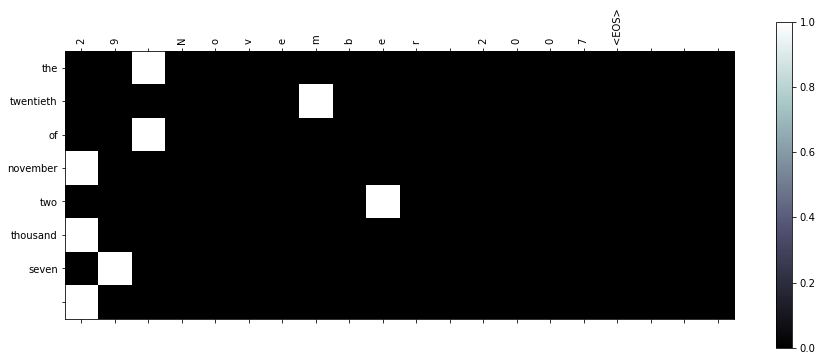

In [54]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input:  ', sample[0])
    print('output: ', decoded_output)
    print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)
    
debug_eval_sample_show_attention()

